In [93]:
import copy
import pywt
import scipy.stats
import scipy.signal
import scipy.io

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from kpnet.handler import *
from kpnet.network import *
from kpnet.signal import *
from kpnet.callback import *
from kpnet.entropy import *
from kpnet.patterns import *
from kpnet.utils import *

from wavelets import *

In [106]:
N = 64
time_interval = 24000

In [107]:
np.random.seed(0)
neuron = 5
# 20, 0.078
# Period - N, 3, alpha=0.044, beta=0.2, gamma=3.2
net = KPNetworkTanhDelayed(N, 3, alpha=0.06, beta=0.2, gamma=3.2)

callbacks = {}
callbacks['W'] = WeightsCallback(time_interval, N)
callbacks['N_0'] = NeuronActivityCallback(time_interval, 0)
callbacks['N_8'] = NeuronActivityCallback(time_interval, 8)
    
signal = SwitchSignal([2000, time_interval], [RandomUnitSignal(N), ZeroSignal(N)])
handler = ComputationHandler(time_interval)
%time results = handler.run(net, signal, callbacks)

CPU times: user 5.39 s, sys: 184 ms, total: 5.57 s
Wall time: 5.58 s


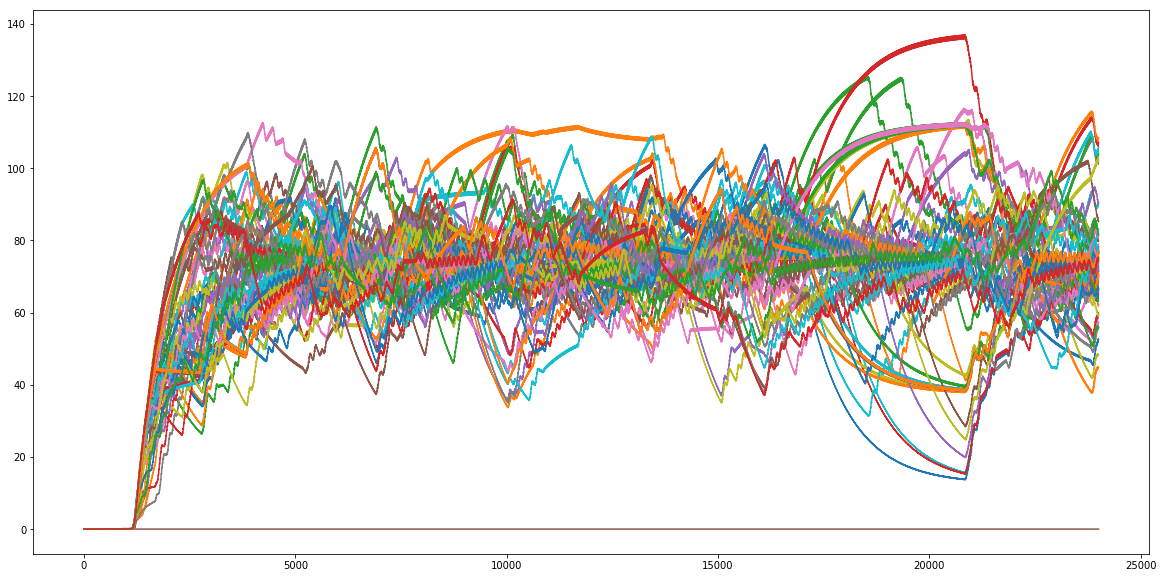

In [109]:
plt.figure(figsize=(20, 10))
for i in range(N):
    plt.plot(results['W'][5, i])
plt.show()

In [55]:
def neuron_cluster(neuron, weights, threshold=0.01):
    neurons = weights.shape[1]
    cwts = [EntropyCWT(weights[neuron, j, :], Ricker()) for j in range(neurons)]
    entropies = np.zeros(shape=(neurons, neurons))
    for j in range(neurons):
        for k in range(neurons):
            entropies[j][k] = EntropyCWT.compare(cwts[j], cwts[k], 
                              EntropyCWT.distribution, EntropyCWT.jensen)
    c = 1
    cs = np.zeros(shape=(neurons, ))
    ents = np.inf + np.zeros(shape=(neurons, ))
    for j in range(neurons):
        if cs[j] == 0:
            found = 0
            for k in range(neurons):
                if entropies[j][k] <= np.min([ents[k], threshold]) and j != k:
                    cs[k] = c
                    ents[k] = entropies[j][k]
                if entropies[j][k] <= np.min([ents[j], threshold]) and j != k:
                    cs[j] = c
                    ents[j] = entropies[j][k]
            c += 1
            
    return cs

In [30]:
def parse_clusters(encoded_clusters, neuron, min_size=1):
    clusters = []
    for num in np.unique(encoded_clusters):
        if num != 0:
            cluster = set()
            for j in range(N):
                if encoded_clusters[j] == num:
                    cluster.add(j)
            if len(cluster) > min_size:
                cluster.add(neuron)
                clusters.append(cluster)
            
    return clusters

In [110]:
clusters = []
for i in range(N):
    cluster = parse_clusters(neuron_cluster(i, results['W'][:, :, 18000:21000], 0.01), i, 5)
    if len(cluster) > 0:
        clusters.append(cluster)

/home/dmitry/Projects/neurodyn/kpnet/entropy.py:14: RuntimeWarning: invalid value encountered in true_divide
  return d / norm


In [102]:
def find_max_intersect(cluster, clusters, collected):
    max_len = 0
    n = -1
    c = -1
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            if not collected[i][j]:
                res = cluster & clusters[i][j]
                if len(res) > max_len:
                    max_len = len(res)
                    n = i
                    c = j
    return n, c

In [113]:
collected = []
for i in range(len(clusters)):
    collected.append([False] * len(clusters[i]))
    
res = []
for i in range(len(clusters)):
    for j in range(len(clusters[i])):
        if not collected[i][j]:
            res.append(copy.deepcopy(clusters[i][j]))
            collected[i][j] = True
            n, c = find_max_intersect(res[-1], clusters, collected)
            while n != -1 and c != -1:
                collected[n][c] = True
                res[-1] &= clusters[n][c]
                n, c = find_max_intersect(res[-1], clusters, collected)

In [149]:
res

[{0}, {14, 56}, {11, 30}, {9, 10, 13, 33}, {35}]

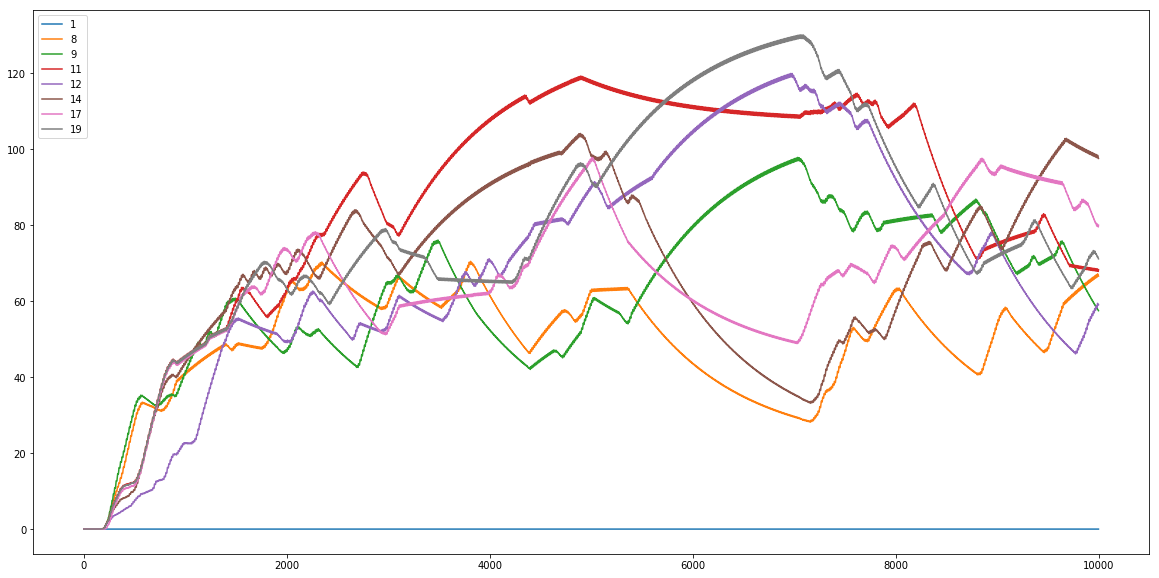

In [83]:
plt.figure(figsize=(20, 10))
for i in range(N):
    if i in clusters[2][0]:
        plt.plot(results['W'][1, i], label=str(i))
plt.legend(loc='upper left')
plt.show()

In [ ]:
wa = WaveletAnalysis(results['W'][5, 9], wavelet=Ricker())

fig = plt.figure(figsize=(20, 10)) 
ax = plt.subplot()
# wa.plot_power(ax)
Time, Scale = np.meshgrid(wa.time, wa.scales)
CS = ax.contourf(Time, Scale, wa.wavelet_power, 100)

ax.set_yscale('log')
ax.grid(True)

coi_time, coi_scale = wa.coi
ax.fill_between(x=coi_time,
                y1=coi_scale,
                y2=wa.scales.max(),
                color='gray',
                alpha=0.3)

ax.set_xlim(wa.time.min(), wa.time.max())
plt.colorbar(CS)
plt.show()

In [ ]:
wa = WaveletAnalysis(results['W'][5, 36], wavelet=Ricker())

fig = plt.figure(figsize=(20, 10)) 
ax = plt.subplot()
# wa.plot_power(ax)
Time, Scale = np.meshgrid(wa.time[18000:21000], wa.scales)
CS = ax.contourf(Time, Scale, wa.wavelet_power[:, 18000:21000], 100)

ax.set_yscale('log')
ax.grid(True)

coi_time, coi_scale = wa.coi
ax.fill_between(x=coi_time,
                y1=coi_scale,
                y2=wa.scales.max(),
                color='gray',
                alpha=0.3)

ax.set_xlim(wa.time.min(), wa.time.max())
plt.colorbar(CS)
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
ent_10 = EntropyCWT(results['W'][5, 2], Ricker()) 
ent_13 = EntropyCWT(results['W'][5, 36], Ricker())
values = EntropyCWT.compare_sliced(1000, ent_10, ent_13, EntropyCWT.distribution, EntropyCWT.jensen)
plt.plot(values)
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
ent_10 = EntropyCWT(results['W'][5, 2], Ricker()) 
ent_13 = EntropyCWT(results['W'][5, 36], Ricker())
values = EntropyCWT.compare_sliced(1000, ent_10, ent_13, WaveletEntropy.distribution, WaveletEntropy.jensen)
plt.plot(results['W'][5, 2] / np.max(results['W'][5, 2]))
plt.plot(results['W'][5, 36] / np.max(results['W'][5, 36]))
plt.plot(np.sqrt(values) / np.sqrt(np.max(values)))
plt.show()

In [115]:
import networkx as nx

In [126]:
g = nx.complete_graph(N)

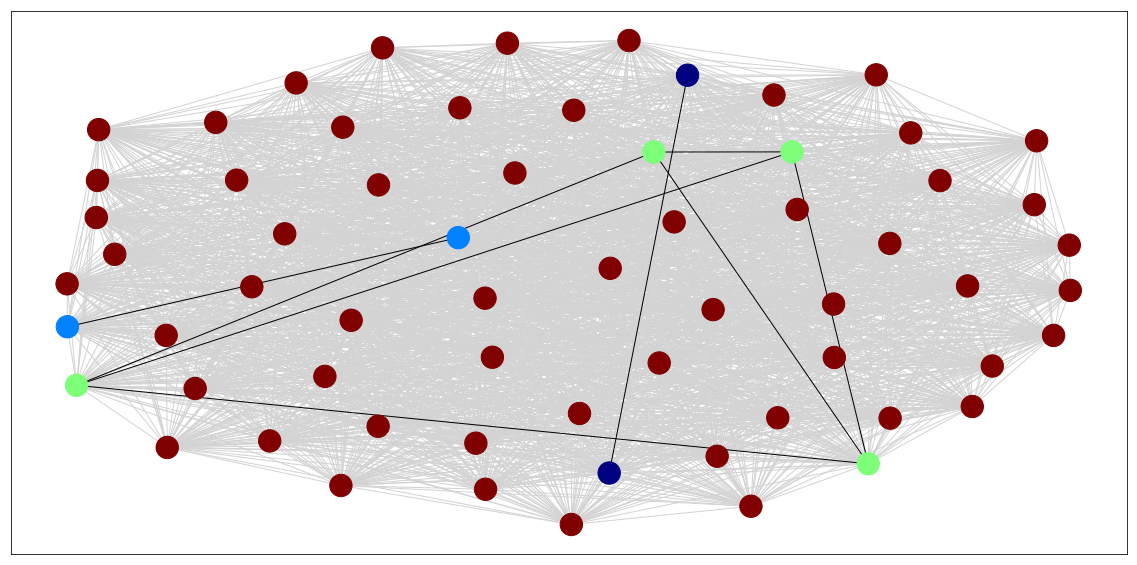

In [165]:
def in_cluster(n, clusters):
    for i, cs in enumerate(res):
        if len(cs) > 1:
            for j in cs:
                if j == n:
                    return i
    return -1
                    
values = [0.5] * N
c = 0.1
for cs in res:
    if len(cs) > 1:
        for n in cs:
            values[n] = c
        c += 0.1
        
         
        
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, cmap=plt.get_cmap('jet'),
                       node_color = values, node_size = 500)

black_edges = [(b, e) for b, e in g.edges() if in_cluster(b, clusters) == in_cluster(e, clusters) and in_cluster(e,clusters) != -1]
white_edges = [edge for edge in g.edges() if edge not in black_edges]
nx.draw_networkx_edges(g, pos, edgelist=white_edges, edge_color='lightgray')
nx.draw_networkx_edges(g, pos, edgelist=black_edges)
plt.xticks([])
plt.yticks([])
plt.show()

In [146]:
res

[{0}, {14, 56}, {11, 30}, {9, 10, 13, 33}, {35}]